In [30]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

In [31]:
songs = pd.read_csv("df_audio_features_5000")
songs.columns=songs.columns.str.strip()
songs["name"] = songs["name"].str.replace(r"\(.*?\)", "").str.replace(r"\[.*?\]", "").str.replace(r"\-.*", "").str.strip()
songs.drop_duplicates(inplace=True)
songs.dropna(inplace=True)

/var/folders/5h/ynhjym0n61gc40kqz70c00d00000gn/T/ipykernel_19031/3393159509.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  songs["name"] = songs["name"].str.replace(r"\(.*?\)", "").str.replace(r"\[.*?\]", "").str.replace(r"\-.*", "").str.strip()


In [32]:
# Scale the numerical columns
scaler = MinMaxScaler()
num_cols = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
songs[num_cols] = scaler.fit_transform(songs[num_cols])

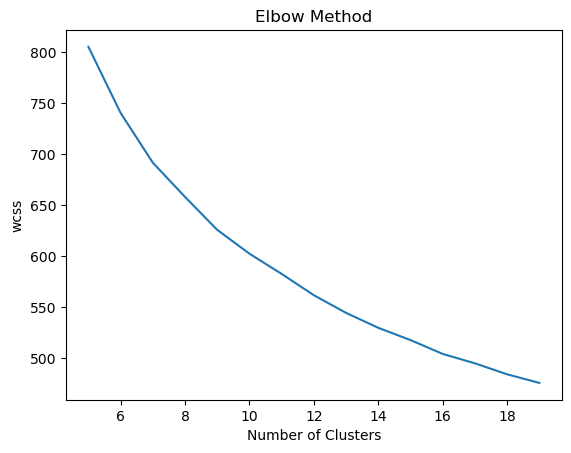

In [34]:
import matplotlib.pyplot as plt # Within-Cluster Sum of Squares

# Determine the optimal number of clusters using the elbow method
wcss = []   # WCSS measures the sum of squared distances between each data point and its assigned cluster centroid
for i in range(5, 20):
    kmeans = KMeans(n_clusters=i, init='k-means++',random_state=303)      #random_state=
    kmeans.fit(songs[num_cols])
    wcss.append(kmeans.inertia_)
plt.plot(range(5, 20), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('wcss') 
plt.show()

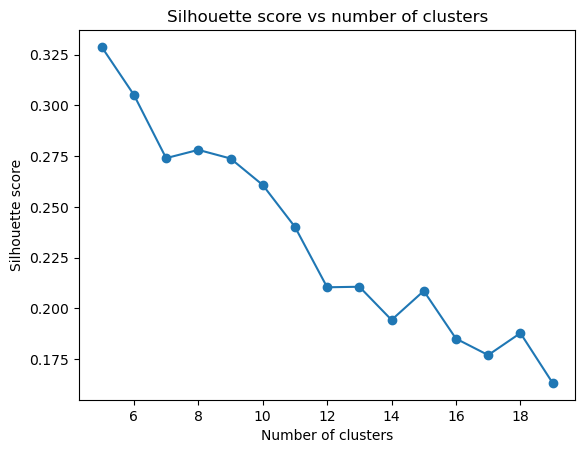

In [35]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Define the range of number of clusters to try
num_clusters_range = range(5, 20)

# Calculate silhouette scores for each number of clusters
silhouette_scores = []
for num_clusters in num_clusters_range:
    kmeans = KMeans(n_clusters=num_clusters,random_state=303)   #random_state=
    cluster_labels = kmeans.fit_predict(songs[num_cols])
    silhouette_scores.append(silhouette_score(songs[num_cols], cluster_labels))

# Plot the silhouette score vs number of clusters
fig, ax = plt.subplots()
ax.plot(num_clusters_range, silhouette_scores, marker='o')
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Silhouette score')
ax.set_title('Silhouette score vs number of clusters')
plt.show()

In [36]:
best_number_of_clusters = []
prev_score = -1
for i, score in enumerate(silhouette_scores):
    if i == 0:
        prev_score = score
        best_number_of_clusters.append(i+15)
    elif score >= prev_score + 0.005:
        prev_score = score
        best_number_of_clusters.append(i+15)
        if len(best_number_of_clusters) == 5:
            break
    else:
        if len(best_number_of_clusters) > 0 and i > best_number_of_clusters[-1] - 15:
            prev_score = score

print("Top five best number of clusters:", best_number_of_clusters)

Top five best number of clusters: [15, 25, 28]


In [37]:
# Fit a KMeans model with 8 clusters
kmeans = KMeans(n_clusters=15, init='k-means++', random_state=303)
kmeans.fit(songs[num_cols])

# Add the cluster labels to the DataFrame
songs['cluster'] = kmeans.labels_

# Print the number of songs in each cluster
print(songs['cluster'].value_counts())

2     673
11    504
1     483
3     468
6     437
0     423
5     367
12    322
9     271
4     267
8     263
10    210
14    196
13    167
7     124
Name: cluster, dtype: int64


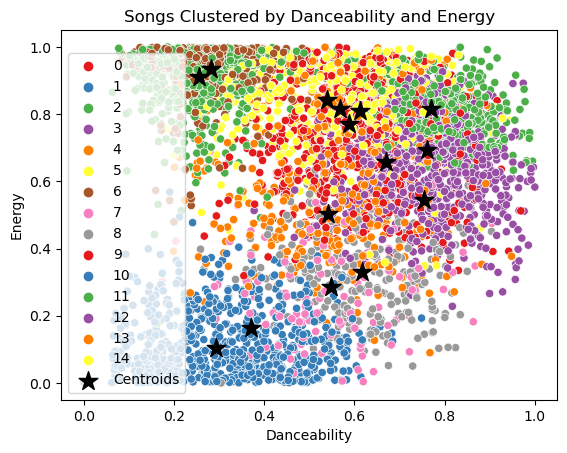

In [38]:
import seaborn as sns

colors = sns.color_palette('Set1', n_colors=15)
sns.scatterplot(x='danceability', y='energy', hue='cluster', palette=colors, data=songs)
# Plot the cluster centroids
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', s=200, color='black', label='Centroids')

# Add plot elements
plt.title('Songs Clustered by Danceability and Energy')
plt.xlabel('Danceability')
plt.ylabel('Energy')
plt.legend()
plt.show()

In [21]:
# Define the number of clusters
num_clusters = 15
import numpy as np
# Define a function to get the distances from each point to its centroid
def get_distances_to_centroid(df, centroids):
    distances = []
    for i, row in df.iterrows():
        point = np.array(list(row[num_cols]))
        centroid_distances = []
        for centroid in centroids:
            centroid_distances.append(np.linalg.norm(point - centroid))
        distances.append(min(centroid_distances))
    return distances

In [22]:
# Get the indices of the most representative songs for each cluster
import numpy as np
representative_song_indices = []
for i in range(num_clusters):
    cluster_df = songs[songs['cluster'] == i]
    distances = get_distances_to_centroid(cluster_df, centroids)
    sorted_indices = np.argsort(distances)
    top_indices = sorted_indices[:min(25, len(sorted_indices))]
    representative_song_indices.extend(cluster_df.iloc[top_indices].index)

# Get the most representative songs DataFrame
representative_songs = songs.loc[representative_song_indices].reset_index(drop=True)

In [23]:
representative_songs.head(2)

,name,artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,duration_ms,time_signature,id,html,cluster
0,Was immer du willst - Radio Version ...,Marlon,0.634953,0.751,0,0.892097,1,0.034314,0.065562,0.000000,0.139818,0.270051,0.617160,,233221,4,4ICxVPF15K0Tp6BaugxYam,https://open.spotify.com/track/4ICxVPF15K0Tp6B...,0
1,Forbidden Voices ...,Martin Garrix,0.552223,0.711,10,0.881500,0,0.040087,0.050201,0.003147,0.136778,0.304569,0.598635,,230635,4,6EsH66Uto1zwZlDGQ6RokU,https://open.spotify.com/track/6EsH66Uto1zwZlD...,0


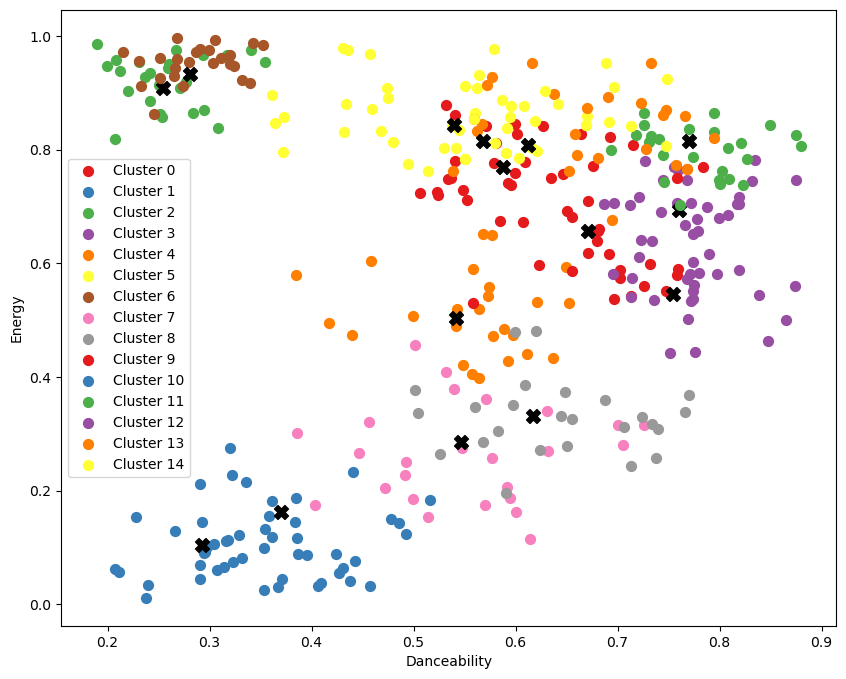

In [24]:
# Plot the most representative songs for each cluster
colors = sns.color_palette('Set1', n_colors=15)
fig, ax = plt.subplots(figsize=(10, 8))
for i in range(num_clusters):
    cluster_df = representative_songs[representative_songs['cluster'] == i]
    ax.scatter(cluster_df['danceability'], cluster_df['energy'], s=50, color=colors[i], label=f'Cluster {i}')
    ax.scatter(centroids[i][0], centroids[i][1], s=100, color='black', marker='X')
ax.legend()
ax.set_xlabel('Danceability')
ax.set_ylabel('Energy')
plt.show()

In [ ]:
colors = sns.color_palette('Set1', n_colors=15)

fig, axs = plt.subplots(2, 2, figsize=(20, 16))

for i in range(num_clusters):
    cluster_df = representative_songs[representative_songs['cluster'] == i]
    
    axs[0,0].scatter(cluster_df['danceability'], cluster_df['energy'], s=50, color=colors[i], label=f'Cluster {i}')
    axs[0,0].scatter(centroids[i][0], centroids[i][1], s=100, color='black', marker='X')
    axs[0,0].set_xlabel('Danceability')
    axs[0,0].set_ylabel('Energy')
    axs[0,0].set_title('Danceability vs Energy')
    
    axs[0,1].scatter(cluster_df['loudness'], cluster_df['speechiness'], s=50, color=colors[i], label=f'Cluster {i}')
    axs[0,1].scatter(centroids[i][2], centroids[i][3], s=100, color='black', marker='X')
    axs[0,1].set_xlabel('Loudness')
    axs[0,1].set_ylabel('Speechiness')
    axs[0,1].set_title('Loudness vs Speechiness')
    
    axs[1,0].scatter(cluster_df['acousticness'], cluster_df['instrumentalness'], s=50, color=colors[i], label=f'Cluster {i}')
    axs[1,0].scatter(centroids[i][4], centroids[i][6], s=100, color='black', marker='X')
    axs[1,0].set_xlabel('Acousticness')
    axs[1,0].set_ylabel('Instrumentalness')
    axs[1,0].set_title('Acousticness vs Instrumentalness')
    
    axs[1,1].scatter(cluster_df['liveness'], cluster_df['valence'], s=50, color=colors[i], label=f'Cluster {i}')
    axs[1,1].scatter(centroids[i][5], centroids[i][7], s=100, color='black', marker='X')
    axs[1,1].set_xlabel('Liveness')
    axs[1,1].set_ylabel('Valence')
    axs[1,1].set_title('Liveness vs Valence')

plt.show()

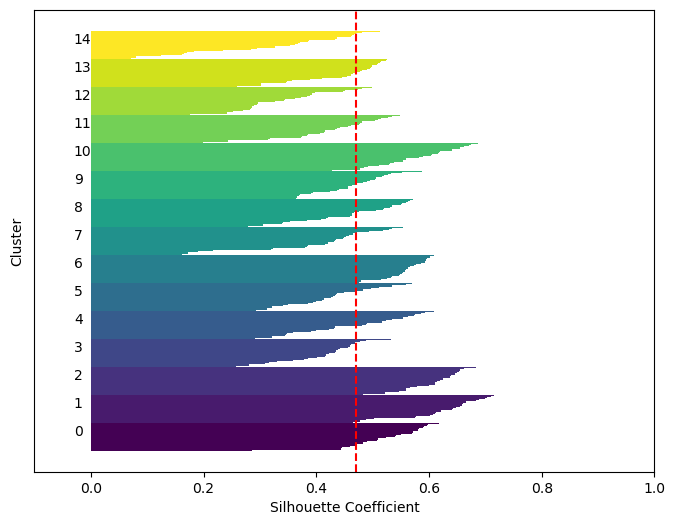

In [28]:
import matplotlib.cm as cm
from sklearn.metrics import silhouette_samples

# Calculate silhouette scores for each sample
silhouette_vals = silhouette_samples(representative_songs[num_cols], representative_songs['cluster'])

# Calculate average silhouette score for each cluster
silhouette_avg = []
for i in range(representative_songs['cluster'].nunique()):
    mask = representative_songs['cluster'] == i
    silhouette_avg.append(silhouette_vals[mask].mean())

# Define color map
cmap = cm.get_cmap('viridis', representative_songs['cluster'].nunique())

# Plot silhouette scores for each sample
fig, ax = plt.subplots(figsize=(8,6))
y_lower, y_upper = 0, 0
for i in range(representative_songs['cluster'].nunique()):
    mask = representative_songs['cluster'] == i
    vals = silhouette_vals[mask]
    vals.sort()
    y_upper += len(vals)
    ax.barh(range(y_lower, y_upper), vals, height=1.0,
            color=cmap(i))
    ax.text(-0.03, (y_lower + y_upper) / 2, str(i))
    y_lower += len(vals)

# Plot average silhouette score for each cluster
silhouette_avg = sum(silhouette_avg) / len(silhouette_avg)
ax.axvline(x=silhouette_avg, color='red', linestyle='--')
ax.set_xlabel('Silhouette Coefficient')
ax.set_ylabel('Cluster')
ax.set_yticks([])
ax.set_xlim([-0.1, 1])
plt.show()

In [55]:
import spotipy
from spotipy.oauth2 import SpotifyOAuth
import pandas as pd

client_id = '1c93c60c32164c1fbf1546e8454537a7'
client_secret = 'e8a5744aac504655a62d546c00d1373b'
redirect_uri = 'http://localhost:3000'
scope = 'playlist-modify-public'

sp = spotipy.Spotify(auth_manager=SpotifyOAuth(client_id=client_id, client_secret=client_secret, redirect_uri=redirect_uri, scope=scope))

for cluster_id in representative_songs['cluster'].unique():
# picked_clusters=[3, 7, 8, 10, 11, 16, 19, 21, 23, 24, 27, 28, 29] 
# for cluster_id in picked_clusters:
    cluster_songs = representative_songs[representative_songs['cluster'] == cluster_id]

    playlist_name = f'Cluster {cluster_id}'
    playlist_description = f'A playlist with representative songs from {cluster_id}'
    playlist = sp.user_playlist_create(user='31m2ihszmyvjvfnyscqbjuz5baqe', name=playlist_name, public=True, description=playlist_description)
    playlist_id = playlist['id']
    
    # Add the songs to the playlist
    song_ids = cluster_songs['id']
    song_ids = [song_id.strip() for song_id in song_ids]
    track_uris = [f'spotify:track:{song_id}' for song_id in song_ids]
    sp.playlist_add_items(playlist_id=playlist_id, items=track_uris)
    print(f'Added {len(track_uris)} songs to {playlist_name}')

Added 25 songs to Cluster 3
Added 25 songs to Cluster 7
Added 25 songs to Cluster 8
Added 25 songs to Cluster 10
Added 25 songs to Cluster 11
Added 25 songs to Cluster 16
Added 25 songs to Cluster 19
Added 25 songs to Cluster 21
Added 25 songs to Cluster 23
Added 25 songs to Cluster 24
Added 25 songs to Cluster 27
Added 25 songs to Cluster 28
Added 25 songs to Cluster 29
